#**Phiên bản lossy của Thien & Lin**


In [ ]:
pip install opencv-python --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
from PIL import Image
import math
import matplotlib. pyplot as plt
import matplotlib. image as mpimg

#### Phân chia tin mật
Quá trình phân chia ảnh mật
* Dùng p = 251, là số nguyên tố lớn nhất ≤ 255
* Với các pixel có giá trị > 250, đổi giá trị thành 250
* Duyệt các pixel theo một thứ tự nào đó, cứ k pixel sẽ tạo
thành một nhóm (không giao với các nhóm khác). Với mỗi
nhóm gồm k pixel p1, p2, ... , pk:
* Tạo đa thức: f x = p1 + p2x + ⋯ + pkx k−1
* Từ đa thức trên tạo ra n phần theo phương pháp Shamir

In [ ]:
def split(p, s_file, n, k):
    '''
    Hàm phân chia tin mật s thành n phần sao cho chỉ khi có ít nhất là k phần (k <= n)
    thì mới tái tạo được s, còn ít hơn k phần thì sẽ không biết gì về s.
    
    Các tham số:
        s_file (string): Tin mật cần chia sẻ.
        n (int): Số phần cần phân chia (số người).
        k (int): Ngưỡng k (k <= n).
    Giá trị trả về:
        2 mảng numpy một chiều: Gọi 2 mảng này là xs và ys,
                                n phần được phân chia: phần thứ 1 là (xs[0], ys[0]),
                                                       phần thứ 2 là (xs[1], ys[1]),
                                                       ...
                                với ys[i] = f(xs[i]).
    '''
    
    # Đọc file chuyển thành mảng
    cover_pixels = cv2.imread(s_file, cv2.IMREAD_GRAYSCALE)
    height, width = cover_pixels.shape[:2]
    width = round(width / k)

    # tạo nhóm k
    g_k = np.zeros((height, width, k))
    for c in range(0, height):
        for r in range(0, width):
            for i in range(0, k):
                g_k[c, r, i] = cover_pixels[c, r + (width * i)]

    f_pixel = np.zeros((height, width, n))
    for c in range(0, height):
        for r in range(0, width):
            ys = []
            for i in range(0, k):
                 # Với các pixel có giá trị > 250, đổi giá trị thành 250
                ys.append(min(g_k[c, r, i], 250))
            for i in range(0, n):
                # Tạo hàm đa thức
                f_pixel[c, r, i] = np.polyval(ys, i)
                f_pixel[c, r, i] = np.mod(f_pixel[c, r, i], p)

    f_pixel = np.uint8(f_pixel)
    for i in range(0, n):
        cv2.imwrite(f'outputs/stego{i}.bmp', f_pixel[:, :, i])

    print('Phân chia ảnh mật thành công')

#### Phục hồi ảnh mật

In [ ]:
def compute_inv(x, y, p):
    if y == 0:
        return 1
    f = math.fmod(compute_inv(x, math.floor(y / 2), p), p)
    f = math.fmod(f * f, p)
    
    if math.fmod(y, 2) == 0:
        return f
    
    return math.fmod(x * f, p)

def compute_frac(delta, max_abs, p):
    max_abs = compute_inv(max_abs, p - 2, p)
    return math.fmod(math.fmod(delta, p) * math.fmod(max_abs , p), p)

def compute_interpolation(xs, ys, p):
    '''
    Tính nội suy Lagrange.
    
    Các tham số:
        xs, ys (2 mảng numpy có cùng len & len = bậc-của-f + 1): ys[i] = f(xs[i]).
        x (int): Giá trị x mà tại đó cần tính f(x) bằng nội suy Lagrange.
    Giá trị trả về:
        int: Giá trị f(x)
    '''
    delta1 = []
    delta2 = []
    k = len(ys)
    for i in range(0, k):
        f1 = 1
        f2 = 1
        for j in range(0, k):
            if j == i:
                continue
            f1 = np.convolve(f1 , [1, -xs[j]])
            f2 = f2 * (xs[i] - xs[j])
        delta1.append(f1)
        delta2.append(f2)

    num = [0]
    max_abs = max(np.abs(delta2))
    for i in range(0, k):
        t = delta1[i] * (max_abs / delta2[i])
        num = num + (ys[i] * t)
    
    f_y = []
    for i in range(len(ys)):
        f_y.append(compute_frac(num[i], max_abs, p))

    return f_y

def join(p, s_file, k, n):
    '''
    Tái tạo tin mật s từ n' phần của tin mật (n' >= k).
    
    Các tham số:
        xs, ys (2 mảng numpy một chiều, len = n'): n' phần của tin mật: phần thứ 1 là (xs[0], ys[0]), 
                                                                        phần thứ 2 là (xs[1], ys[1]), 
                                                                        ...
        k (int): Ngưỡng k mà đã dùng khi phân chia tin mật.
    Giá trị trả về:
        int: Tin mật s được tái tạo,
               trong trường hợp không đủ số phần để tái tạo tin mật thì trả về None.
    '''
    # TODO
    filenames = []
    for i in range(0, n):
        filenames.append(f'outputs/{s_file}{i}.bmp')
    
    img = cv2.imread(filenames[0])
    height, width = img.shape[:2]
    
    #print(filenames)
    array_pixel = []
    n_prime = k
    rand_idxs = np.random.permutation(np.arange(len(filenames)))
    filenames =  [filenames[i] for i in rand_idxs[:n_prime]]
    result = np.zeros((height, width * k))
    
    xs = rand_idxs[:n_prime]
    for i in range(0, height):
        for j in range(0, width):
            ys = []
            for img in filenames:
                data = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                ys.append(data[i, j])
            s = compute_interpolation(xs, ys, p)
            for r in range(0, k):
                result[i, j + (width * r)] = s[r]
            
    cv2.imwrite(f'outputs/stego.bmp', np.uint8(result))
    print('Phục hồi thành công')

In [ ]:
# Phân chia tin mật
s = 'cover.bmp'
p = 251
k = 2
n = 8 
split(p, s, n, k)
join(p, 'stego', k, n)

Phân chia ảnh mật thành công
Phục hồi thành công


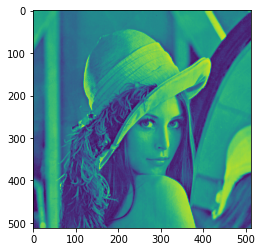

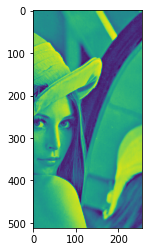

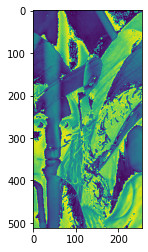

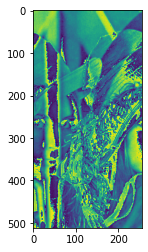

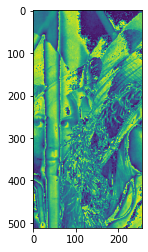

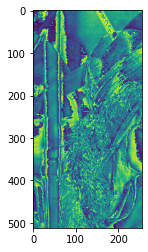

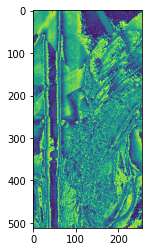

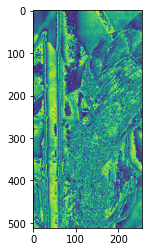

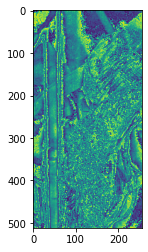

In [ ]:
img = mpimg. imread('outputs/stego.bmp')
imgplot = plt.imshow(img)
plt. show()
for i in range(0, n):
  name = 'stego' + str(i)
  img = mpimg. imread('outputs/'+name+'.bmp')
  imgplot = plt.imshow(img)
  plt. show()

#**Phiên bản LossLess của Thien & Lin**


#### Quá trình phân chi ảnh mật:
Giống như phiên bản lossy, chỉ khác là:
* Không có vụ đổi giá trị của các pixel mà > 250 thành 250
* Thay vì làm trên mảng các pixel của I thì sẽ chuyển mảng các pixel của I thành một mảng khác và sẽ làm trên mảng khác này
Cách chuyển: duyệt mảng các pixel của I:
* Nếu giá trị pixel < 250: ghi giá trị pixel vào vị trí tương ứng của mảng khác
* Nếu giá trị pixel ≥ 250: tách giá trị pixel thành 2 giá trị là 250 và phần còn lại, rồi ghi 2 giá trị này vào 2 vị trí tương ứng của mảng khác
* -> Số lượng phần tử của mảng khác ≥ số lượng phần tử của I

In [ ]:
def convert_pixel(pixel):
    if pixel >= 250:
        new_pixel = [250, pixel - 250]
    else:
        new_pixel = pixel
    return new_pixel
def split_lole(p, s_file, n, k):
    # Đọc file chuyển thành mảng
    cover_pixels = cv2.imread(s_file, cv2.IMREAD_GRAYSCALE)
    height, width = cover_pixels.shape[:2]
    width = round(width / k)
    
    # tạo nhóm k
    g_k = np.zeros((height, width, k))
    for c in range(0, height):
        for r in range(0, width):
            for i in range(0, k):
                g_k[c, r, i] = cover_pixels[c, r + (width * i)]

    f_pixel = np.zeros((height, width, n))
    for c in range(0, height):
        for r in range(0, width):
            ys = []
            for i in range(0, k):
                ys.append(convert_pixel(g_k[c, r, i]))
            for i in range(0, n):
                # Tạo hàm đa thức
                f_pixel[c, r, i] = np.polyval(ys, i)
                f_pixel[c, r, i] = np.mod(f_pixel[c, r, i], p)

    f_pixel = np.uint8(f_pixel)
    for i in range(0, n):
        cv2.imwrite(f'lossless_outputs/stego{i}.bmp', f_pixel[:, :, i])

    print('Phân chia ảnh mật thành công')

#### Phục hồi ảnh mật
* Nếu theo đúng các bước của phiên bản lossy thì cuối cùng ta sẽ ra được mảng khác
* Để ra được mảng các pixel của I thì ta sẽ duyệt các phần tử trong mảng khác này:
* -> Nếu phần tử có giá trị ≠ 250: ghi giá trị này vào vị trí tương ứng trong mảng I
* -> Nếu phần tử có giá trị = 250: lấy thêm phần tử kế trong mảng khác, cộng 2 giá trị này lại và ghi kết quả vào vị trí tương ứng trong mảng I

In [ ]:
def join_lole(p, s_file, k, n):
    '''
    Tái tạo tin mật s từ n' phần của tin mật (n' >= k).

    Các tham số:
        xs, ys (2 mảng numpy một chiều, len = n'): n' phần của tin mật: phần thứ 1 là (xs[0], ys[0]), 
                                                                        phần thứ 2 là (xs[1], ys[1]), 
                                                                        ...
        k (int): Ngưỡng k mà đã dùng khi phân chia tin mật.
    Giá trị trả về:
        int: Tin mật s được tái tạo,
                trong trường hợp không đủ số phần để tái tạo tin mật thì trả về None.
    '''
    
    filenames = []
    for i in range(0, n):
        filenames.append(f'lossless_outputs/{s_file}{i}.bmp')
    
    img = cv2.imread(filenames[0])
    height, width = img.shape[:2]
    array_pixel = []
    n_prime = k
    rand_idxs = np.random.permutation(np.arange(len(filenames)))
    filenames =  [filenames[i] for i in rand_idxs[:n_prime]]
    result = np.zeros((height, width * k))
    xs = rand_idxs[:n_prime]
    for i in range(0, height):
        for j in range(0, width):
            ys = []
            for img in filenames:
                data = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                ys.append(data[i, j])
            s = compute_interpolation(xs, ys, p)
            for r in range(0, k):
                if(s[r] != 250):
                  result[i, j + (width * r)] = s[r]
                else:
                  result[i, j + (width * r)] = s[r] + s[r+1]
    
    cv2.imwrite(f'lossless_outputs/stego.bmp', np.uint8(result))
    print('Phục hồi thành công')

In [ ]:
# Phân chia tin mật
s = 'cover.bmp'
p = 251
k = 4
n = 7
split_lole(p, s, n, k)
join_lole(p, 'stego', k, n)

Phân chia ảnh mật thành công
Phục hồi thành công


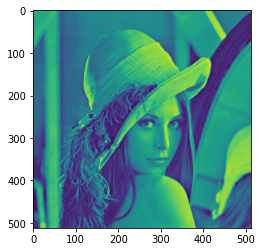

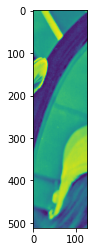

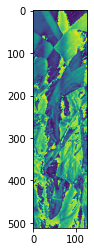

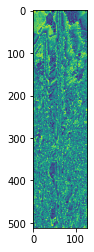

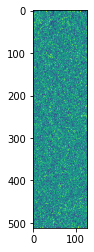

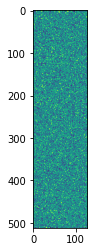

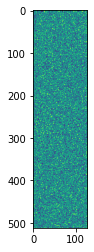

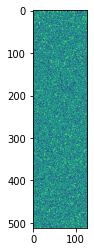

In [ ]:
img = mpimg. imread('lossless_outputs/stego.bmp')
imgplot = plt.imshow(img)
plt. show()
for i in range(0, n):
  name = 'stego' + str(i)
  img = mpimg. imread('lossless_outputs/'+name+'.bmp')
  imgplot = plt.imshow(img)
  plt. show()
